## Overview from Orem

Present your findings to the class in a compelling way, speaking for 10 minutes or so (if you have more to share and just can't help it, you are welcome to run over that). You don't need to cover everything in your analysis, focus on the fun / interesting / compelling highlights or challenges. A clean notebook with good visualizations (pre-run, don't need to run it live; please do have it cleaned up for a presentation context) or slides would both be fine, whatever works for your team.

Please note that a given sub-area (PCA, or hyperparameter optimization, etc.) may not be that meaningful for your particular dataset. It is fine to emphasize one area less and another area more.

The point totals below are more guidelines. Explaning your dataset is important, the main focus is on supervised learning, and dimensionality reduction and clustering can (sometimes) give us cool insights. I won't be viewing the presentations and subtracting points for not mentioning a certain line item. The real goal is "show your peers some cool analysis of data, demonstrating that you have learned to apply the key ideas of the course to a novel dataset".

As always, please feel free to email me with any questions.


### 5 pts: introduce your dataset to the audience. Here are some suggested key points.

- how many features? how many rows?
- continuous or categorical? missing data?
- What is your dependent variable? regression or classification? distribution?
- did you need to perform any data exploration, cleaning, transformation?


### 10 pts: perform some thoughtful supervised learning, including engineering and selecting features, selecting and optimizing a model, and explaining your model (coefficients or feature importance, performance). Here are some suggested key points.

- feature engineering / selection, bivariate charts? Interactions?
- missing data? how to handle it?
- Selection of modeling algorithm? classification or regression? binary or multi-class?
- interpretation of variable importance, coefficients if applicable
- justification of choice of metric (accuracy, precision / recall, other?)
- is class weighting or over / under sampling appropriate?
- discussion of choice or tuning of hyperparameters, if any
- meaningful discussion of predictive power and conclusions from model
- look at misclassified examples from test dataset, what do they say about your model?
- outliers in data?


### 5 pts: PCA as data exploration and visualization. Here are some suggested key points.

- take a look at PCA, percent explained
- take a look at top eigenvector or two, what is it made out of?
- can you visualize your prediction problem by projecting to 2 dimensions?


### 5 pts: k-means as data exploration and visualization. Here are some suggested key points.

- discussion for choosing number of clusters
- analysis of cluster centers
- scatter plot(s) showing 2 dimensional perspective of clusters and cluster centers?
- meaningful interpretation / discussion of conclusions

## Load data

In [2]:

import pandas as pd
import numpy as np

#lost code for this ds, but thankfully I had the csv saved. this is the same as the clean_speeddating_with_na.csv ds but I removed all the binned columns and the has_null column
df = pd.read_csv("clean_speeddating_with_na_removed_bins.csv", low_memory=False)
df = df.applymap(lambda x: np.nan if x == '?' else x)


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#also get rid of decision and decision_o and like because that would give it away. and get rid of the first two unnamed columns (not sure where they came from?)
#df = df.drop(['decision', 'decision_o', 'like'], axis=1)
df.drop(df.columns[[0]], axis=1, inplace=True)
#df.to_csv('clean_speeddating_with_na_no_bins2.csv')


In [3]:
df.shape

(8378, 62)

## Feature selection using kbest

#### first pre process

In [4]:
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#from mlxtend.preprocessing import DenseTransformer
from sklearn.preprocessing import StandardScaler

##first have to preprocess

#make an encoder for all the categorical columns
encoder = OneHotEncoder(handle_unknown='infrequent_if_exist')
categorical_cols = ["gender", "race", "race_o", "field"]

#standard scale all numeric columns since some are on scale of 0-100 and some from 1-10 and some are binary (like same_race)
std_scaler = StandardScaler()
all_cols = df.columns.tolist()
numeric_cols = [col for col in all_cols if col not in categorical_cols]
numeric_cols.remove('match')

#now use a column transformer to do both pre processors on their separate columns
transformer = ColumnTransformer( 
        [('categories', encoder, categorical_cols),
        ('numeric', std_scaler, numeric_cols)],
        sparse_threshold=0,
        remainder='drop', verbose_feature_names_out=False)

#### then split ds

In [5]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'match']
y = df['match']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [6]:
#turns out kMeans can't process nans so drop them and try again
df_no_nan = df.dropna()

X2 = df_no_nan.loc[:, df_no_nan.columns != 'match']
y2 = df_no_nan['match']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=0)

X_train2.shape


(3646, 61)

#### then kbest

In [7]:
transformer.fit(X_train2, y_train2)

feature_selector = SelectKBest(k=10)

X_train_trans2 = transformer.transform(X_train2)

type(X_train_trans2)


X_train_trans_df2 = pd.DataFrame(X_train_trans2, columns = transformer.get_feature_names_out())

feature_selector.fit(X_train_trans_df2, y_train2)

SelectKBest()

<Axes: >

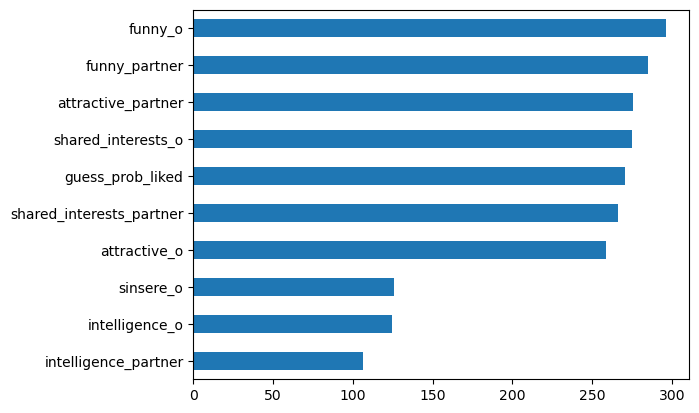

In [8]:
X_train_trans_df2.columns[feature_selector.get_support()]

top_feature_importance_scores = feature_selector.scores_[feature_selector.get_support()]

top_feature_importance_names = X_train_trans_df2.columns[feature_selector.get_support()]

pd.Series(top_feature_importance_scores, index=top_feature_importance_names).sort_values(ascending=True).plot(kind='barh')

## moving forward I'll just use these top 10 features

In [9]:
top10 = ['funny_o', 'funny_partner', 'attractive_partner', 'guess_prob_liked', 'shared_interests_partner', 'attractive_o', 'sinsere_o', 'intelligence_o', 'intelligence_partner']

In [10]:
#resplit the data using only the top features. still had to use the non-nan data for the models below
X_top10 = df_no_nan[top10]
y_top10 = df_no_nan['match']

X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(X_top10, y_top10, random_state=0)

## Try ensemble to see which models work the best

In [11]:
from sklearn.naive_bayes import BernoulliNB #choosing Bernoulli since have binary outcome
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#three models that might work well. not using hyperparameters yet
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = BernoulliNB()

#ensemble
eclf = VotingClassifier(
    estimators=[('lr', clf1), ('rf', clf2), ('bnb', clf3)],
    voting='hard')

#find accuracies using cross validated scores
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_train_top10, y_train_top10, scoring='accuracy', cv=5) #using the split dataset without nans
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.85 (+/- 0.01) [Logistic Regression]
Accuracy: 0.85 (+/- 0.00) [Random Forest]
Accuracy: 0.83 (+/- 0.00) [naive Bayes]
Accuracy: 0.85 (+/- 0.01) [Ensemble]


## They were all pretty good but Random Forest was the best. Try finding hyperparameters for random forest

#### first set up preprocessor and model

In [12]:
#have to re-process with only the top 10 columns
transformer_top10 = ColumnTransformer(
        [('numeric', std_scaler, top10)],
        remainder='drop', verbose_feature_names_out=False)

In [13]:
#set up pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

classification_pipeline = Pipeline([('transformer', transformer_top10),
                                    ('RF_model', RandomForestClassifier())])

In [14]:
#find names of parameters
classification_pipeline.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                    ['funny_o', 'funny_partner',
                                     'attractive_partner', 'guess_prob_liked',
                                     'shared_interests_partner', 'attractive_o',
                                     'sinsere_o', 'intelligence_o',
                                     'intelligence_partner'])],
                     verbose_feature_names_out=False)),
  ('RF_model', RandomForestClassifier())],
 'verbose': False,
 'transformer': ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                  ['funny_o', 'funny_partner',
                                   'attractive_partner', 'guess_prob_liked',
                                   'shared_interests_partner', 'attractive_o',
                                   'sinsere_o', 'intelligence_o',
                                   'intelligence_part

In [15]:
#set up parameters. want to do randomized search
from scipy.stats import randint, uniform

parameters = {
    "RF_model__max_depth": randint(3, 30),
    "RF_model__min_impurity_decrease": uniform(loc=0, scale=0.1),
    'RF_model__min_samples_leaf': randint(2, 10)
} #nothing to hyperparameterize from transfomer since only used the standard scalar in it (all top10 columns were numeric)

In [16]:
#fit model to best parameters
from sklearn.model_selection import RandomizedSearchCV

n_iter_search = 10

random_search = RandomizedSearchCV(classification_pipeline, param_distributions=parameters, n_iter=n_iter_search, n_jobs=-1, verbose=True)

random_search.fit(X_train_top10, y_train_top10)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               StandardScaler(),
                                                                               ['funny_o',
                                                                                'funny_partner',
                                                                                'attractive_partner',
                                                                                'guess_prob_liked',
                                                                                'shared_interests_partner',
                                                                                'attractive_o',
                                                                                'sinsere_o',
                                                                                'intelligence_o',
                                                                                'intelligence_partner'])],
                                                                verbose_feature_names_out=False)),
                                             ('RF_model',
                                              RandomForestClassifi...
                   n_jobs=-1,
                   param_distributions={'RF_model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13128be10>,
                                        'RF_model__min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x132aaa550>,
                                        'RF_model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x132ab4f10>},
                   verbose=True)

In [17]:
random_search.best_score_ 
#still best score is only 86%

0.8332420091324201

In [18]:
random_search.best_estimator_
#best max_depth = 23
#best min_impurity_decrease = 0.0008982385551574712
#best min_samples_leaf = 9

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['funny_o', 'funny_partner',
                                                   'attractive_partner',
                                                   'guess_prob_liked',
                                                   'shared_interests_partner',
                                                   'attractive_o', 'sinsere_o',
                                                   'intelligence_o',
                                                   'intelligence_partner'])],
                                   verbose_feature_names_out=False)),
                ('RF_model',
                 RandomForestClassifier(max_depth=3,
                                        min_impurity_decrease=0.011594643623011637,
                                        min_samples_leaf=8))])

#### then cross validate

In [19]:
scores = cross_val_score(random_search, X_train_top10, y_train_top10, cv=5)
print(scores.mean(), '\t', scores.std())
#still about 85%

#not sure if this step is necessary? is this part of the randomized search?

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.8406494165398275 	 0.006282630210991793


#### then repeat with test data to find true accuracy

In [20]:
#set up classification for test data
classification_pipeline_test = Pipeline([('transformer', transformer_top10),
                                    ('RF_model', RandomForestClassifier(max_depth=23, min_impurity_decrease=0.0008982385551574712, min_samples_leaf=9))])

#fit and predict
classification_pipeline_test.fit(X_train_top10, y_train_top10)
classification_pipeline_test.predict(X_test_top10)


array([0, 0, 0, ..., 0, 0, 0])

In [21]:
#find accuracy
y_pred = classification_pipeline_test.predict(X_test_top10)
sum(y_pred == y_test_top10) / len(y_test_top10)

#87% accurate!!

0.8486842105263158

#### confusion matrix

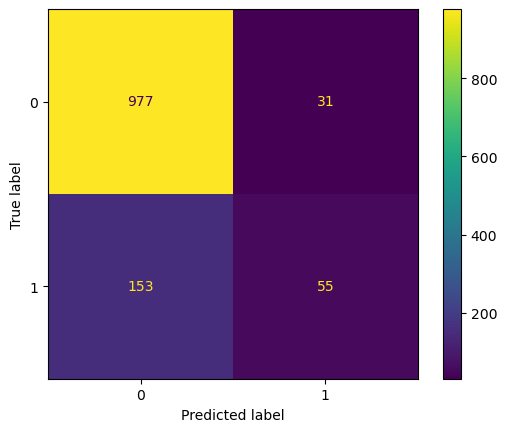

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test_top10, y_pred), display_labels=classification_pipeline_test.classes_).plot()

## not many people match in general. does not do a good job at identifying who matches. will retry with all features rather than top 10

#### transform data and find which model works best

In [23]:
#first transform the data since have categorical and numeric data types. use transformer from before
X_train_trans2 = transformer.fit_transform(X_train2)

#find which model works best from all features (from non-nan ds)
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = cross_val_score(clf, X_train_trans2, y_train2, scoring='accuracy', cv=5) 
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))



/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Accuracy: 0.85 (+/- 0.01) [Logistic Regression]
Accuracy: 0.85 (+/- 0.01) [Random Forest]
Accuracy: 0.80 (+/- 0.01) [naive Bayes]


/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

Accuracy: 0.85 (+/- 0.01) [Ensemble]


#### ensemble does best. set up pipeline then find hyperparameters

In [24]:
classification_pipeline2 = Pipeline([('transformer', transformer_top10),
                                    ('ensemble', VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('bnb', clf3)], voting='hard'))])

In [25]:
#find names of parameters
classification_pipeline2.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                    ['funny_o', 'funny_partner',
                                     'attractive_partner', 'guess_prob_liked',
                                     'shared_interests_partner', 'attractive_o',
                                     'sinsere_o', 'intelligence_o',
                                     'intelligence_partner'])],
                     verbose_feature_names_out=False)),
  ('ensemble',
   VotingClassifier(estimators=[('lr', LogisticRegression(random_state=1)),
                                ('rf', RandomForestClassifier(random_state=1)),
                                ('bnb', BernoulliNB())]))],
 'verbose': False,
 'transformer': ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                  ['funny_o', 'funny_partner',
                                   'attractive_partner', 'guess_prob_liked',
          

In [26]:
parameters2 = {
    "ensemble__lr__penalty": ("None", "l2", "l1", "elasticnet"),
    "ensemble__rf__max_depth": range(3,30),
    'ensemble__rf__min_samples_leaf': range(2, 10),
    "ensemble__bnb__alpha": (0.0, 1.0)
}

In [27]:
#had to do grid search this time since needed to spell out the logistic regression parameter options
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(classification_pipeline2, parameters2, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train2, y_train2)


Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/U

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['funny_o',
                                                                          'funny_partner',
                                                                          'attractive_partner',
                                                                          'guess_prob_liked',
                                                                          'shared_interests_partner',
                                                                          'attractive_o',
                                                                          'sinsere_o',
                                                                          'intelligence_o',
                                                                          'intelligence_partner'])],
                                                          verbose_feature_names_out=False)),
                                       ('ensemble',
                                        VotingClassifier(estimators=[('lr',
                                                                      LogisticRegression(random_state=1)),
                                                                     ('rf',
                                                                      RandomForestClassifier(random_state=1)),
                                                                     ('bnb',
                                                                      BernoulliNB())]))]),
             n_jobs=-1,
             param_grid={'ensemble__bnb__alpha': (0.0, 1.0),
                         'ensemble__lr__penalty': ('None', 'l2', 'l1',
                                                   'elasticnet'),
                         'ensemble__rf__max_depth': range(3, 30),
                         'ensemble__rf__min_samples_leaf': range(2, 10)},
             verbose=1)

In [28]:
grid_search.best_score_


0.8535405837123674

In [29]:
grid_search.best_estimator_
#ensemble__lr__penalty='None'
#ensemble__rf__max_depth=10,
#ensemble__rf__min_samples_leaf=2
#ensemble__bnb__alpha=0.0

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['funny_o', 'funny_partner',
                                                   'attractive_partner',
                                                   'guess_prob_liked',
                                                   'shared_interests_partner',
                                                   'attractive_o', 'sinsere_o',
                                                   'intelligence_o',
                                                   'intelligence_partner'])],
                                   verbose_feature_names_out=False)),
                ('ensemble',
                 VotingClassifier(estimators=[('lr',
                                               LogisticRegression(random_state=1)),
                                              ('rf',
                                               RandomForestClassifier(max_depth=14,
                                                                      min_samples_leaf=6,
                                                                      random_state=1)),
                                              ('bnb',
                                               BernoulliNB(alpha=0.0))]))])

#### repeat for test data and find accuracy

In [31]:
#transform test data
X_test_trans2 = transformer.fit_transform(X_test2)

#convert to df
X_test_trans_df2 = pd.DataFrame(X_test_trans2, columns = transformer.get_feature_names_out(),
                                index = X_test2.index)

#fit and predict
grid_search.fit(X_train_trans_df2, y_train2)
grid_search.predict(X_test_trans_df2)


Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:624: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/naive_bayes.py:633: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/U

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
#find accuracy
y_pred2 = grid_search.predict(X_test_trans_df2)
sum(y_pred2 == y_test2) / len(y_test2)

0.84375

#### confusion matrix

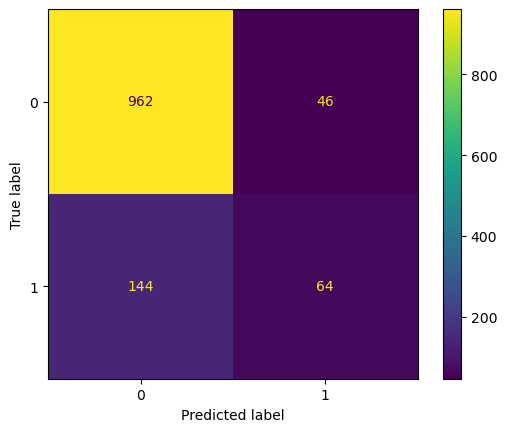

In [33]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test2, y_pred2), display_labels=grid_search.classes_).plot()

## same problem as before, it just doesn't do a good job at identifying matches since there are so few. will try weighing. will use the top10 features since that had a higher accuracy

In [34]:
classification_pipeline_balanced = Pipeline([('transformer', transformer_top10),
                                    ('RF_model', RandomForestClassifier(max_depth=23, min_impurity_decrease=0.0008982385551574712, min_samples_leaf=9, class_weight='balanced'))])

In [35]:
scores3 = cross_val_score(classification_pipeline_balanced, X_train_top10, y_train_top10, cv=5)
print(scores3.mean(), '\t', scores3.std())

#goes down to 80% when balanced weights

0.7731788714132702 	 0.01346325209526529


In [36]:
#fit and predict
classification_pipeline_balanced.fit(X_train_top10, y_train_top10)
classification_pipeline_balanced.predict(X_test_top10)

array([0, 0, 1, ..., 0, 0, 1])

In [37]:
#find accuracy
y_pred3 = classification_pipeline_balanced.predict(X_test_top10)
sum(y_pred3 == y_test_top10) / len(y_test_top10)



0.7491776315789473

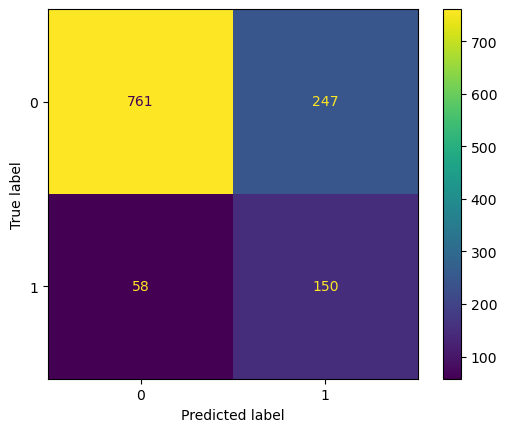

In [38]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test_top10, y_pred3), display_labels=classification_pipeline_balanced.classes_).plot()

#### balanced weights does predict matches much better, but it also misses non matches more

# PCA

In [39]:
X_train2.head()

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches,guess_prob_liked,met
3750,female,27.0,24.0,3,asian/pacific islander/asian-american,other,0,4.0,4.0,genetics,20.0,20.0,25.0,25.0,5.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,19.0,20.0,19.0,14.0,13.0,15.0,6.0,9.0,7.0,9.0,6.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,6.0,7.0,9.0,5.0,5.0,6.0,2.0,3.0,9.0,6.0,7.0,7.0,9.0,9.0,5.0,3.0,-0.18,6.0,4.0,4.0,0.0
310,female,22.0,28.0,6,latino/hispanic american,european/caucasian-american,0,1.0,5.0,speech language pathology,40.0,20.0,20.0,20.0,0.0,0.0,9.0,9.0,8.0,9.0,8.0,7.0,17.0,10.0,18.0,20.0,25.0,10.0,6.0,6.0,7.0,7.0,7.0,2.0,4.0,7.0,3.0,6.0,2.0,7.0,6.0,8.0,8.0,7.0,6.0,8.0,7.0,8.0,8.0,5.0,5.0,5.0,5.0,7.0,7.0,8.0,-0.06,5.0,1.0,2.0,0.0
640,male,30.0,27.0,3,european/caucasian-american,european/caucasian-american,1,2.0,2.0,finance&economics,10.0,20.0,20.0,15.0,20.0,15.0,5.0,7.0,7.0,7.0,7.0,7.0,20.0,20.0,25.0,25.0,5.0,5.0,8.0,7.0,9.0,9.0,3.0,6.0,6.0,6.0,5.0,6.0,4.0,6.0,7.0,2.0,8.0,7.0,6.0,3.0,7.0,4.0,7.0,4.0,5.0,8.0,8.0,7.0,2.0,1.0,0.04,8.0,5.0,6.0,0.0
4685,male,25.0,33.0,8,european/caucasian-american,european/caucasian-american,1,7.0,8.0,computer science,20.0,25.0,25.0,10.0,15.0,5.0,7.0,5.0,7.0,3.0,6.0,2.0,24.0,15.0,20.0,20.0,8.0,13.0,7.0,6.0,8.0,7.0,4.0,6.0,8.0,7.0,5.0,5.0,5.0,2.0,2.0,3.0,7.0,6.0,6.0,3.0,8.0,5.0,9.0,8.0,7.0,9.0,5.0,6.0,5.0,3.0,0.17,6.0,2.0,4.0,0.0
8124,male,23.0,26.0,3,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,2.0,industrial engineering/operations research,40.0,5.0,30.0,15.0,5.0,5.0,4.0,4.0,2.0,1.0,5.0,5.0,40.0,30.0,0.0,20.0,0.0,10.0,8.0,9.0,9.0,9.0,8.0,8.0,8.0,10.0,7.0,6.0,5.0,10.0,10.0,7.0,8.0,3.0,5.0,4.0,3.0,8.0,3.0,10.0,5.0,10.0,10.0,9.0,9.0,3.0,-0.10,7.0,1.0,5.0,0.0


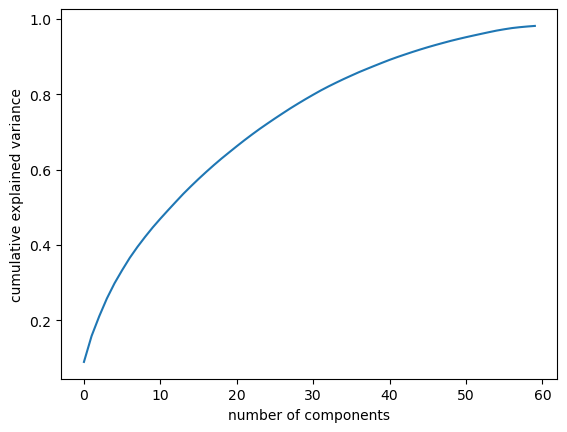

In [40]:
from sklearn.decomposition import PCA

pca = Pipeline([('transformer', transformer),
                         ('pca', PCA(60))]) #first start with most of the features

pca.fit(X_train2) #pca can't handle nan entries either


pca['pca']

import matplotlib.pyplot as plt

plt.plot(np.cumsum(pca['pca'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [41]:
pca_pipeline = Pipeline([('transformer', transformer),
                         ('scaler', StandardScaler()),
                         ('pca', PCA(25)),
                         ('RF', RandomForestClassifier())]) #use RF since performed best before - but should we use this one or ensemble?

pca_pipeline.fit(X_train2, y_train2)

y_pred = pca_pipeline.predict(X_test2)

sum(y_pred == y_test2)/len(y_test2)

#86% accurate still with PCA and RF (unoptimized)

0.850328947368421

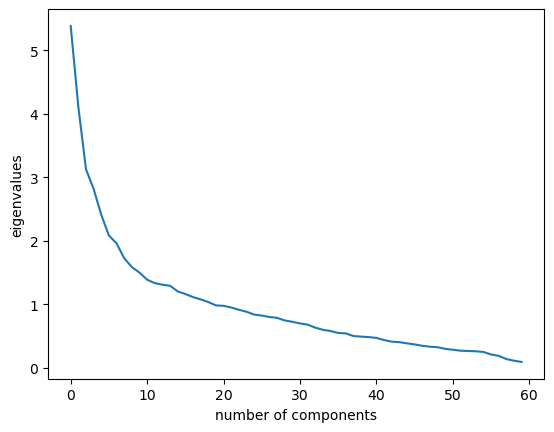

In [42]:
plt.plot(pca.steps[1][1].explained_variance_)
plt.xlabel('number of components')
plt.ylabel('eigenvalues');

/var/folders/f_/6qh4fqhd4sdg10xsh3wzc6fc0000gn/T/ipykernel_95788/3814541780.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent_r', 2))


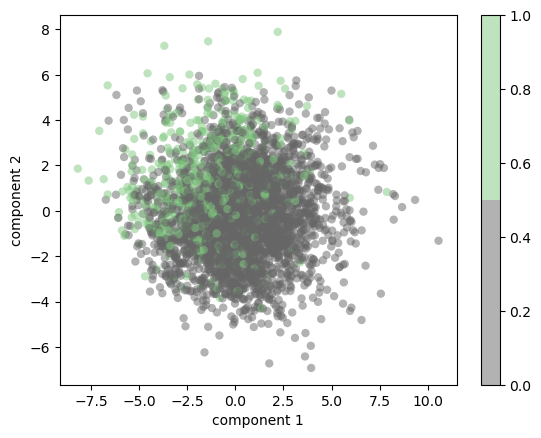

In [43]:
pca2 = Pipeline([('transformer', transformer),
                         ('pca', PCA(2))]) #project to 2 dimensions
projected = pca2.fit_transform(X_train2)

plt.scatter(projected[:, 0], projected[:, 1],
            c=y_train2, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent_r', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

KMeans

In [57]:
df_no_nan.head()

,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches,guess_prob_liked,met,match
0,female,21.0,27.0,6,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,4.0,law,35.0,20.0,20.0,20.0,0.0,5.0,6.0,8.0,8.0,8.0,8.0,6.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,6.0,9.0,7.0,7.0,6.0,5.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.14,3.0,4.0,6.0,0.0,0
1,female,21.0,22.0,1,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,4.0,law,60.0,0.0,0.0,40.0,0.0,0.0,7.0,8.0,10.0,7.0,7.0,5.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,8.0,7.0,8.0,5.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.54,3.0,4.0,5.0,1.0,0
3,female,21.0,23.0,2,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,4.0,law,30.0,5.0,15.0,40.0,5.0,5.0,7.0,8.0,9.0,8.0,9.0,8.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,7.0,6.0,8.0,7.0,6.0,8.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.61,3.0,4.0,6.0,0.0,1
4,female,21.0,24.0,3,asian/pacific islander/asian-american,latino/hispanic american,0,2.0,4.0,law,30.0,10.0,20.0,10.0,10.0,20.0,8.0,7.0,9.0,6.0,9.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,5.0,6.0,7.0,7.0,6.0,6.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.21,3.0,4.0,6.0,0.0,1
5,female,21.0,25.0,4,asian/pacific islander/asian-american,european/caucasian-american,0,2.0,4.0,law,50.0,0.0,30.0,10.0,0.0,10.0,7.0,7.0,8.0,8.0,7.0,7.0,15.0,20.0,20.0,15.0,15.0,15.0,6.0,8.0,8.0,8.0,7.0,4.0,9.0,7.0,4.0,6.0,4.0,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,0.25,3.0,4.0,5.0,0.0,0


In [59]:
from sklearn.preprocessing import LabelEncoder

df_kmeans = df_no_nan.copy()

number = LabelEncoder()
df_kmeans["gender"] = number.fit_transform(df_kmeans["gender"].astype('str'))
df_kmeans["race"] = number.fit_transform(df_kmeans["race"].astype('str'))
df_kmeans["race_o"] = number.fit_transform(df_kmeans["race_o"].astype('str'))
df_kmeans["field"] = number.fit_transform(df_kmeans["field"].astype('str'))

df_kmeans.isna().sum()



gender                           0
age                              0
age_o                            0
d_age                            0
race                             0
race_o                           0
samerace                         0
importance_same_race             0
importance_same_religion         0
field                            0
pref_o_attractive                0
pref_o_sincere                   0
pref_o_intelligence              0
pref_o_funny                     0
pref_o_ambitious                 0
pref_o_shared_interests          0
attractive_o                     0
sinsere_o                        0
intelligence_o                   0
funny_o                          0
ambitous_o                       0
shared_interests_o               0
attractive_important             0
sincere_important                0
intellicence_important           0
funny_important                  0
ambtition_important              0
shared_interests_important       0
attractive          

In [60]:
df_onehot = df_kmeans.copy()
df_onehot = pd.get_dummies(df_onehot, columns = ['gender','race','race_o','field'], prefix = ['gender','race','race_o','field'])

In [61]:
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
onehot_fit_trans = SS.fit_transform(df_onehot)

onehot_fit_trans

array([[-1.47427058,  0.23332291,  0.82941822, ..., -0.04306417,
        -0.18859946, -0.0453983 ],
       [-1.47427058, -1.21068927, -0.86524953, ..., -0.04306417,
        -0.18859946, -0.0453983 ],
       [-1.47427058, -0.92188684, -0.52631598, ..., -0.04306417,
        -0.18859946, -0.0453983 ],
       ...,
       [-0.34198979, -1.21068927, -0.18738243, ..., -0.04306417,
        -0.18859946, -0.0453983 ],
       [-0.34198979,  0.23332291, -0.52631598, ..., -0.04306417,
        -0.18859946, -0.0453983 ],
       [-0.34198979, -1.21068927, -0.18738243, ..., -0.04306417,
        -0.18859946, -0.0453983 ]])

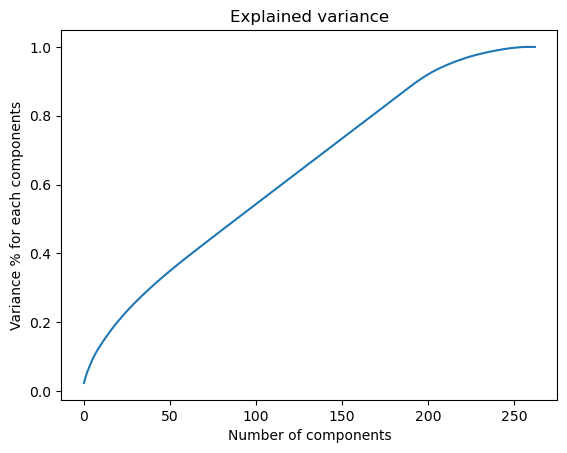

In [62]:
pca=PCA().fit(onehot_fit_trans)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance % for each components')
plt.title('Explained variance')
plt.show()

In [64]:
pca=PCA(n_components=200)
pca.fit(onehot_fit_trans)
x_pca=pca.transform(onehot_fit_trans)

/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/christinalawrence/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: 

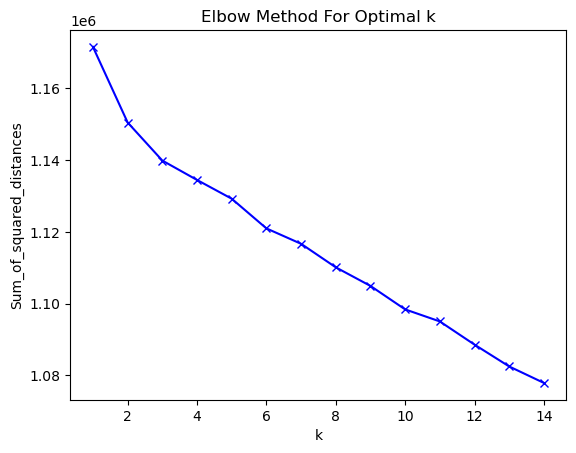

In [66]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x_pca)
    Sum_of_squared_distances.append(km.inertia_)
#Visualing the plot
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

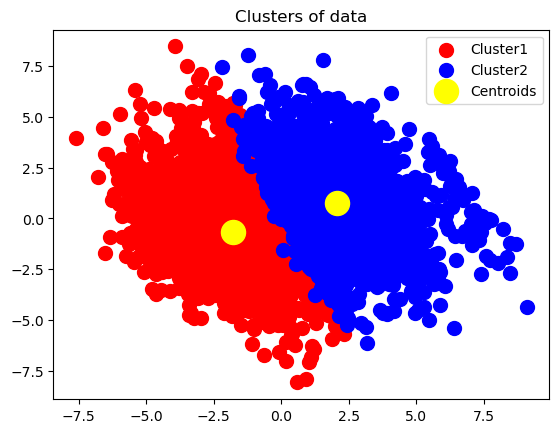

In [72]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=1000, tol=0.0001, verbose=0, random_state=None, copy_x=True)
y_kmeans=kmeans.fit_predict(x_pca)
#Plotting through K-Means
plt.scatter(x_pca[y_kmeans==0,0],x_pca[y_kmeans==0,1],s=100,c='red',label='Cluster1')
plt.scatter(x_pca[y_kmeans==1,0],x_pca[y_kmeans==1,1],s=100,c='blue',label='Cluster2')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],s=300,c='yellow',label='Centroids')
plt.title('Clusters of data')
plt.legend()
plt.show()